# 문서 벡터(Word2Vec)를 이용한 도서 추천 시스템

In [1]:
!wget -c https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2022-01-29 06:31:41--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.78.30
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.78.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  46.3MB/s    in 40s     

2022-01-29 06:32:21 (39.7 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [2]:
!gzip -d GoogleNews-vectors-negative300.bin.gz

In [3]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
from google.colab import files
up = files.upload()

Saving books.csv to books.csv


In [5]:
df = pd.read_csv('books.csv')
df.head(3)

,Unnamed: 0,Desc,Unnamed: 0.1,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...


In [6]:
df.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)
df.head(3)

,Desc,author,genre,image_link,rating,title
0,We know that power is shifting: From West to E...,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,Following the success of The Accidental Billio...,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,How to tap the power of social software and ne...,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...


- 데이터 전처리

In [7]:
# 결측치 확인
df.isnull().sum().sum()

0

In [8]:
# title, desc 중복 확인
df.shape, df.title.nunique(), df.Desc.nunique()

((2382, 6), 2378, 2361)

In [11]:
df.drop_duplicates(subset=['title'], inplace=True)
df.drop_duplicates(subset=['Desc'], inplace=True)
df.shape

(2359, 6)

- 텍스트 전처리

In [12]:
# 구둣점 제거, 소문자 변환
df['clean_doc'] = df.Desc.str.replace('[^A-Za-z ]','').str.lower()

In [13]:
# Stopwords 제거
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
stops = set(stopwords.words('english'))
def remove_stopwords(text):
    l = text.split()
    text = [word for word in l if word not in stops]
    return ' '.join(text)

In [16]:
remove_stopwords('a quick brown fox')

'quick brown fox'

In [17]:
# html 제거
def remove_html(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

In [18]:
df.clean_doc = df.clean_doc.apply(remove_stopwords)
df.clean_doc = df.clean_doc.apply(remove_html)
df.clean_doc.head()

0    know power shifting west east north south pres...
1    following success accidental billionaires mone...
2    tap power social software networks build busin...
3    william j bernstein american financial theoris...
4    amazing book joined steve jobs many akio morit...
Name: clean_doc, dtype: object

In [19]:
# 빈 값('')이 생긴 행 - 삭제
df.clean_doc.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.shape

(2358, 7)

In [28]:
df.tail(3)

,Desc,author,genre,image_link,rating,title,clean_doc
2379,In 1951 John Wyndham published his novel The D...,John Wyndham,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.02,The Day of the Triffids,john wyndham published novel day triffids mode...
2380,This now classic book revealed Flannery O'Conn...,Flannery O'Connor,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.22,A Good Man is Hard to Find and Other Stories,classic book revealed flannery oconnor one ori...
2381,Imbued on every page with Frank McCourt's asto...,Frank McCourt,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.11,Angela's Ashes,imbued every page frank mccourts astounding hu...


In [29]:
df.set_index('title', inplace=True)
df.reset_index(inplace=True)
df.tail(3)

,title,Desc,author,genre,image_link,rating,clean_doc
2355,The Day of the Triffids,In 1951 John Wyndham published his novel The D...,John Wyndham,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.02,john wyndham published novel day triffids mode...
2356,A Good Man is Hard to Find and Other Stories,This now classic book revealed Flannery O'Conn...,Flannery O'Connor,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.22,classic book revealed flannery oconnor one ori...
2357,Angela's Ashes,Imbued on every page with Frank McCourt's asto...,Frank McCourt,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.11,imbued every page frank mccourts astounding hu...


In [21]:
# 토큰화된 코퍼스
corpus = [line.split() for line in df.clean_doc]
print(corpus[0])

['know', 'power', 'shifting', 'west', 'east', 'north', 'south', 'presidential', 'palaces', 'public', 'squares', 'formidable', 'corporate', 'behemoths', 'nimble', 'startups', 'slowly', 'surely', 'men', 'women', 'power', 'merely', 'shifting', 'dispersing', 'also', 'decaying', 'power', 'today', 'constrained', 'risk', 'losing', 'ever', 'end', 'power', 'awardwinning', 'columnist', 'former', 'foreign', 'policy', 'editor', 'moiss', 'nam', 'illuminates', 'struggle', 'oncedominant', 'megaplayers', 'new', 'micropowers', 'challenging', 'every', 'field', 'human', 'endeavor', 'drawing', 'provocative', 'original', 'research', 'nam', 'shows', 'antiestablishment', 'drive', 'micropowers', 'topple', 'tyrants', 'dislodge', 'monopolies', 'open', 'remarkable', 'new', 'opportunities', 'also', 'lead', 'chaos', 'paralysis', 'nam', 'deftly', 'covers', 'seismic', 'changes', 'underway', 'business', 'religion', 'education', 'within', 'families', 'matters', 'war', 'peace', 'examples', 'abound', 'walks', 'life', 'e

- 사전 훈련된 Word2Vec 사용

In [22]:
from gensim.models import Word2Vec, KeyedVectors
model = Word2Vec(size=300, window=5, min_count=2, workers=-1)
model.build_vocab(corpus)

In [23]:
model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)
model.train(corpus, total_examples=model.corpus_count, epochs=15)

(0, 0)

- 단어 벡터의 평균 구하기

In [24]:
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in model.wv.vocab:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = model[word]
                else:
                    doc2vec = doc2vec + model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [25]:
document_embedding_list = get_document_vectors(df.clean_doc)
document_embedding_list[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


array([ 9.03212093e-03,  5.51991090e-02,  2.53676157e-03,  6.82215691e-02,
       -4.81423177e-02, -4.61997539e-02,  2.80902926e-02, -4.83864397e-02,
        6.82229400e-02,  5.20506017e-02, -1.74869020e-02, -7.21204355e-02,
       -2.76475865e-02,  6.94690272e-02, -8.65055993e-02,  5.97000755e-02,
        1.82300508e-02,  6.65536597e-02,  2.99307369e-02, -5.25205098e-02,
       -1.26102334e-02,  6.36094250e-03, -6.18055230e-03,  3.06511894e-02,
        2.76332721e-02, -1.35359569e-02, -7.80941844e-02,  3.98729965e-02,
        2.55513676e-02, -5.13827838e-02, -1.87443309e-02,  1.07790306e-02,
       -3.54190879e-02,  1.22602200e-02,  3.54185849e-02, -1.93221122e-02,
       -3.14616179e-03, -6.41522743e-03,  5.69860116e-02,  4.39840369e-02,
        6.98797256e-02, -2.53522582e-02,  6.07168749e-02,  1.17520625e-02,
       -2.46053021e-02, -3.81216370e-02, -2.79119741e-02,  3.71948928e-02,
       -1.21375301e-03,  1.76342595e-02,  1.27029242e-02,  5.93349105e-03,
       -3.93094271e-02, -

In [26]:
len(document_embedding_list)

2358

- 코사인 유사도

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(document_embedding_list, document_embedding_list)

In [30]:
indices = pd.Series(df.index, index=df.title)

In [35]:
def get_recommendation(title, cos_sim=cos_sim):
    index = indices[title]
    sim_scores = pd.Series(cos_sim[index])
    book_indices = sim_scores.sort_values(ascending=False).head(6).tail(5).index
    return df.title.iloc[book_indices]

In [36]:
get_recommendation('The Day of the Triffids')

1608            The Passage
1718       The Tiger's Wife
1881    The Age of Miracles
2076             The Lacuna
1789         Into the Water
Name: title, dtype: object

- 도서 이미지 출력

In [33]:
import requests
from io import BytesIO

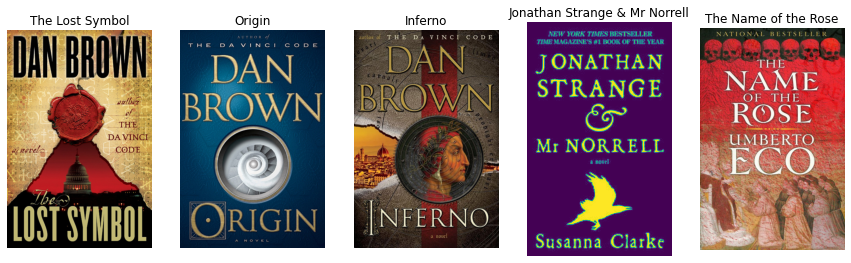

In [39]:
results = get_recommendation('The Da Vinci Code')
plt.figure(figsize=(15,5))
for i, idx in enumerate(results.index):
    response = requests.get(df.image_link[idx])
    img = Image.open(BytesIO(response.content))
    plt.subplot(1, 5, i+1)
    plt.imshow(img), plt.axis('off')
    plt.title(df.title[idx])

plt.show()